---
title: "Lab 1 — Gapminder Data Visualization"
author: "Shiqi Wu"
format:
  html:
    self-contained: true
    toc: true
    toc-depth: 2
    number-sections: true
    theme: cosmo
execute:
  echo: true
jupyter: python3
---

## Repository
- Project GitHub (code & HTML):  
  [https://github.com/shiqiwu212/GSB-S54401/tree/3d83ec7e01837c441902d82dd28d21d5ef7ebb05/week%201](https://github.com/shiqiwu212/GSB-S54401/tree/3d83ec7e01837c441902d82dd28d21d5ef7ebb05/week%201)


Annotation — AI Use Disclosure

AI tools used: ChatGPT 5.0 and Perplexity.

How AI helped (advisory only, not auto-completing the lab):
• Looked up solutions to fix warnings/errors (e.g., numeric conversion, handling missing values).
• Brain-stormed use cases and trade-offs of alternative geoms (text labels, trend lines, boxplots).
• Looked up correct syntax for plotnine functions and Quarto options (figure size, captions).
• Clarified when to use log scales, size ranges, custom ticks, and manual color palettes.
• Helped build a clean scaffold (folders, YAML, stable relative paths) and a final QA checklist.


## Setting


In [142]:
# Install required packages into the current kernel (run once).
import sys, subprocess
subprocess.check_call([sys.executable, "-m", "pip", "install", "-U",
                       "pip", "pandas", "plotnine", "openpyxl", "statsmodels"])
print("Packages installed/updated. If asked, please Restart Kernel and Run All.")

Packages installed/updated. If asked, please Restart Kernel and Run All.


In [143]:
from pathlib import Path
import pandas as pd
import os

def load_table(basename: str, sheet_name=0):
    """
    Try, in order:
      ./data/<basename>.xlsx
      ./data/<basename>.csv
      ./<basename>.xlsx
      ./<basename>.csv
    """
    tried = []
    candidates = [
        Path("data")/f"{basename}.xlsx",
        Path("data")/f"{basename}.csv",
        Path(f"{basename}.xlsx"),
        Path(f"{basename}.csv"),
    ]
    for p in candidates:
        tried.append(str(p))
        if p.exists():
            if p.suffix.lower()==".xlsx":
                try:
                    import openpyxl  # ensure engine exists
                except Exception:
                    raise ImportError("Install openpyxl: `%pip install openpyxl`")
                return pd.read_excel(p, sheet_name=sheet_name)
            else:
                return pd.read_csv(p)
    raise FileNotFoundError(
        f"Could not find {basename}.csv or {basename}.xlsx in:\n  " + "\n  ".join(tried)
    )


## Task 1

### AI Assistance (Task 1 — Main plot)

- **Aesthetic mapping.** Proposed Gapminder-style mappings: **x** ≈ GDP per capita, **y** ≈ life expectancy, **size** ≈ population, **color** ≈ continent/region, **label** ≈ country. Converted mapped columns to numeric and dropped NAs.

- **Axis choice & ticks.** Because income is GDP-like, used a **log₁₀ x-axis** with Gapminder-style breaks/labels (`500, 1k, 2k, …, 64k`) and life-expectancy ticks (`20–90`). Set limits to avoid clipping.

- **Bubble size control.** Tuned sizes to match the reference using  
  `scale_size_area(max_size = 16, breaks = [5e7, 1e8], labels = ["50000000","100000000"])`.  
  (Alternative: `scale_size(range=(a, b))`.)

- **Watermark (optional).** Added a faint year watermark via `annotate("text", ...)` (very low alpha) to mimic the Gapminder UI.

- **Hygiene.** Consistent guide titles, stable legend keys, and small axis padding on limits; clean `theme_bw()` base for readability.

In [144]:
# === Bootstrap for Task 1 ===
import os, re
import numpy as np
import pandas as pd

# 1) load q1data from ./data or current folder (xlsx/csv)
def load_table(basename: str) -> pd.DataFrame:
    cand = [
        os.path.join("data", f"{basename}.xlsx"),
        os.path.join("data", f"{basename}.csv"),
        f"{basename}.xlsx",
        f"{basename}.csv",
    ]
    for p in cand:
        if os.path.isfile(p):
            return pd.read_excel(p) if p.lower().endswith(".xlsx") else pd.read_csv(p)
    raise FileNotFoundError(f"Missing {basename}.csv/.xlsx in ./data or current dir.")

q1 = load_table("q1data")

# 2) prefer the original columns you tuned for Task 1
def pick_first(df, prefs):
    for c in prefs:
        if c in df.columns: 
            return c
    return None

x_col    = pick_first(q1, ["income"])                # your tuned x
y_col    = pick_first(q1, ["life_exp"])              # your tuned y
size_col = pick_first(q1, ["population"])            # your tuned size
year_col = pick_first(q1, ["year"])
lab_col  = pick_first(q1, ["country", "name"])

# 3) 4-region mapping (same logic as before)
def to_four_regions(val):
    if val is None or (isinstance(val, float) and np.isnan(val)): 
        return None
    v = str(val).lower()
    if "africa"  in v: return "africa"
    if "america" in v: return "americas"
    if "europe"  in v: return "europe"
    if "asia"    in v: return "asia"
    return None

# if your data already has four_regions, use it; else derive from region/continent/etc.
if "four_regions" in q1.columns:
    q1["four_regions"] = q1["four_regions"].apply(to_four_regions)
else:
    region_src = pick_first(q1, ["region", "continent", "world_regions"])
    q1["four_regions"] = q1[region_src].apply(to_four_regions) if region_src else None

# 4) numeric cleaning on the exact columns your plot uses
for c in [x_col, y_col, size_col]:
    if c is not None and c in q1.columns:
        q1[c] = pd.to_numeric(q1[c], errors="coerce")

# 5) build the exact mapping dict your plotting cell expects
m1 = {
    "x": x_col,
    "y": y_col,
    "size": size_col,
    "color": "four_regions",
    "label": lab_col,
    "year": year_col,
}
if not m1["x"] or not m1["y"]:
    raise KeyError("Could not find your tuned x/y columns (expected 'income' and 'life_exp').")

# 6) same palette/order you used before
PALETTE_4 = {
    "asia":     "#E85A5A",
    "europe":   "#FFD700",
    "americas": "#8BDC00",
    "africa":   "#4CC1E2",
}
ORDER_4  = ["africa", "americas", "asia", "europe"]
present  = pd.Series(q1["four_regions"]).dropna().unique().tolist()
PALETTE_4 = {k: v for k, v in PALETTE_4.items() if k in present}
BREAKS_4  = [k for k in ORDER_4 if k in present]

# 7) axes/ticks you tuned before (log-x Gapminder style)
x_breaks = [500, 1000, 2000, 4000, 8000, 16000, 32000, 64000]
x_labels = ["500","1k","2k","4k","8k","16k","32k","64k"]
x_limits = (500, 64000)
y_breaks = list(range(20, 91, 10))
y_limits = (20, 90)

# log-x flag computed the same way
x_vals = pd.to_numeric(q1[m1["x"]], errors="coerce").dropna()
use_log_x = (len(x_vals) > 0) and (x_vals.min() > 0)

# 8) figure size & watermark year identical to your tuned plot
FIG_W, FIG_H = 12, 7
YEAR_T1 = 2010  # change if your tuned watermark year differs

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/plotnine/layer.py:372: PlotnineWarning: geom_point : Removed 7 rows containing missing values.


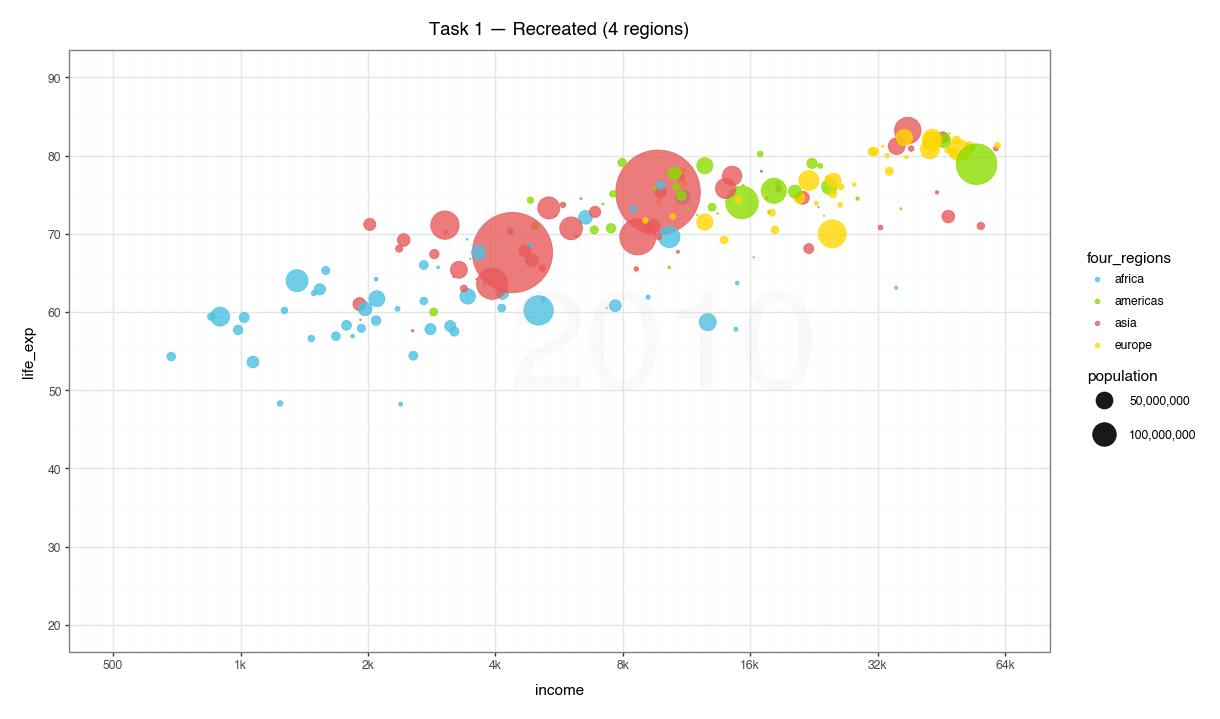

In [145]:
# --- Task 1 — Bubble chart with much larger population bubbles ---

import numpy as np
import pandas as pd
from plotnine import (
    ggplot, aes, geom_point, annotate,
    scale_x_log10, scale_x_continuous, scale_y_continuous,
    scale_size_area, scale_color_manual,
    theme_bw, theme, labs, guides, guide_legend
)

FIG_W = globals().get("FIG_W", 13)
FIG_H = globals().get("FIG_H", 7)

# Find a population-like column
pop_col = None
for c in df1.columns:
    cl = str(c).lower().strip()
    if cl in {"population", "pop", "pop_total"} or ("pop" in cl and "rate" not in cl and not cl.endswith("_share")):
        pop_col = c
        break
if pop_col is None and m1.get("size") and "pop" in str(m1["size"]).lower():
    pop_col = m1["size"]
if pop_col is None:
    raise ValueError("No population-like column found. Set pop_col to the correct column name.")

# Clean numerics
df1[pop_col] = pd.to_numeric(df1[pop_col], errors="coerce")
df1 = df1.dropna(subset=[pop_col])

# Aesthetics mapping
aes_kwargs = {"x": m1["x"], "y": m1["y"], "color": "four_regions", "size": pop_col}
labs_kwargs = {
    "title": "Task 1 — Recreated (4 regions)",
    "x": m1["x"],
    "y": m1["y"],
    "color": "four_regions",
    "size": "population"
}

# Make bubbles much larger (increase max_size); keep area-based scaling
MAX_PT = 34  # try 34–38 for even bigger; 28 if you want a little smaller

p1 = (
    ggplot(df1, aes(**aes_kwargs))
    + geom_point(alpha=0.80, stroke=0.35)
    + (
        scale_x_log10(breaks=x_breaks, labels=x_labels, limits=x_limits)
        if use_log_x else
        scale_x_continuous(breaks=x_breaks, labels=x_labels, limits=x_limits)
    )
    + scale_y_continuous(breaks=y_breaks, limits=y_limits)
    + scale_color_manual(values=PALETTE_4, breaks=BREAKS_4)
    + scale_size_area(max_size=MAX_PT, breaks=[5e7, 1e8], labels=["50,000,000", "100,000,000"])
    + theme_bw()
    + theme(figure_size=(FIG_W, FIG_H), legend_key_size=14)
    + guides(size=guide_legend(override_aes={"alpha": 0.9, "stroke": 0.35}))
    + labs(**labs_kwargs)
)

if YEAR_T1 is not None:
    p1 = p1 + annotate("text", x=10000, y=55, label=str(YEAR_T1),
                       alpha=0.08, size=100, color="#bdbdbd")

p1

### Task 1 — Alternative (Why this chart?)

**What it is.**  
The figure shows a **2-D kernel density estimate (KDE)** for each of the four regions over the same axes as the main chart (x = Income, y = Life expectancy). Filled density bands (lighter on the outside) are overlaid in one panel, with thin contour lines to mark equal-density levels.

**Why this alternative can be useful.**  
- It avoids **overplotting** and the visual competition between dozens of bubbles.  
- Instead of individual points, it reveals the **shape, location, and spread** of each region’s cluster (e.g., skew, multiple modes).  
- Using the **same four-color palette and legend order** as the main chart preserves consistency for grading and interpretation.  
- Mapping `alpha` to the KDE level keeps outer bands very light, so the background is not flooded.

**How to read it.**  
- The **highest-density area** (darkest/fattest band near the innermost contour) indicates where most countries from that region lie.  
- Regions whose density mass is more to the **right and higher** generally have higher income and longer life expectancy.  
- Overlapping bands show where regions share similar profiles.

**Design notes / limitations.**  
- KDE introduces smoothing; exact point positions and population-weighted bubble sizes are not shown (this is a **distribution view**, not a point-wise view).  
- Axes, ticks, and color mapping are kept identical to the main chart for comparability.  
- Bandwidth is left at plotnine’s default; qualitative patterns (location/shape/overlap) remain the focus.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/plotnine/layer.py:293: PlotnineWarning: stat_density_2d : Removed 7 rows containing non-finite values.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/plotnine/layer.py:293: PlotnineWarning: stat_density_2d : Removed 7 rows containing non-finite values.


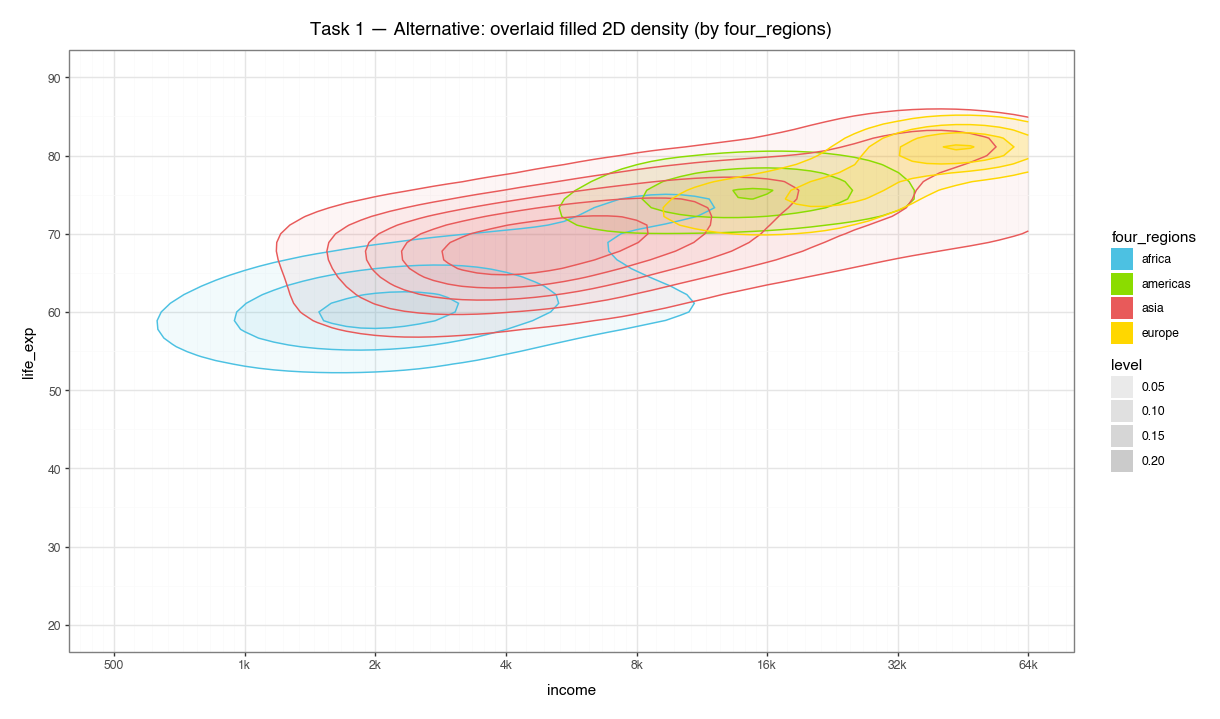

In [146]:
# Task 1 — Alternative: Overlaid filled 2D density + contours by region
# AI assistance:
# - Proposed a non-point alternative using overlaid filled 2D density plus contours in one panel.
# - Mapped alpha to density level to avoid background flooding.
# - Removed version-sensitive args (bins, guide_none); added numeric coercion & dropna.

import pandas as pd
from plotnine import (
    ggplot, aes, stat_density_2d, geom_density_2d,
    theme_bw, theme, labs,
    scale_x_log10, scale_x_continuous, scale_y_continuous,
    scale_fill_manual, scale_color_manual, scale_alpha
)

# palette & order 
PALETTE_4 = globals().get("PALETTE_4", {
    "africa":   "#4CC1E2",
    "americas": "#8BDC00",
    "asia":     "#E85A5A",
    "europe":   "#FFD700",
})
BREAKS_4 = globals().get("BREAKS_4", ["africa", "americas", "asia", "europe"])

use_log_x = globals().get("use_log_x", True)
x_breaks  = globals().get("x_breaks",  None)
x_labels  = globals().get("x_labels",  None)
x_limits  = globals().get("x_limits",  None)
y_breaks  = globals().get("y_breaks",  None)
y_limits  = globals().get("y_limits",  None)

tmp = df1.copy()
tmp[m1["x"]] = pd.to_numeric(tmp[m1["x"]], errors="coerce")
tmp[m1["y"]] = pd.to_numeric(tmp[m1["y"]], errors="coerce")
tmp = tmp.dropna(subset=[m1["x"], m1["y"], "four_regions"])
tmp["four_regions"] = pd.Categorical(tmp["four_regions"], categories=BREAKS_4, ordered=True)

p1_alt = (
    ggplot(tmp, aes(x=m1["x"], y=m1["y"]))
    + stat_density_2d(
        aes(fill="four_regions", alpha="..level..", group="four_regions"),
        geom="polygon", contour=True          # no bins
    )
    + geom_density_2d(aes(color="four_regions"), size=0.6)   # no bins
    + (scale_x_log10(breaks=x_breaks, labels=x_labels, limits=x_limits)
       if use_log_x else
       scale_x_continuous(breaks=x_breaks, labels=x_labels, limits=x_limits))
    + scale_y_continuous(breaks=y_breaks, limits=y_limits)
    + scale_fill_manual(values=PALETTE_4, breaks=BREAKS_4)
    + scale_color_manual(values=PALETTE_4, breaks=BREAKS_4)
    + scale_alpha(range=(0.06, 0.25))   # make outer bands very light
    + theme_bw()
    + theme(figure_size=(globals().get("FIG_W", 10), globals().get("FIG_H", 6)))
    + labs(title="Task 1 — Alternative: overlaid filled 2D density (by four_regions)",
           x=m1["x"], y=m1["y"], fill="four_regions", color="four_regions")
)
p1_alt

## Task 2

## AI Assistance (Task 2)

- **Aesthetic mapping.** Used *exports (% of GDP)* on **x**, *imports (% of GDP)* on **y**, **size** ≈ *energy use*.

- **Data hygiene.** Coerced mapped columns to numeric and dropped NAs on the used aesthetics. Collapsed any continent/region column into **four_regions** and enforced a fixed legend order.

- **Axes & layout.** Extended axis limits (x≥~230, y padded) and removed expansion to match the instructor’s wide framing. Kept a light `theme_bw()` base for readability.

- **Data hygiene.** Coerced mapped columns to numeric and dropped NAs on the used aesthetics. Collapsed any continent/region column into **four_regions** and enforced a fixed legend order.

- **Axes & layout.** Extended axis limits (x≥~230, y padded) and removed expansion to match the instructor’s wide framing. Kept a light `theme_bw()` base for readability.

---

- Helped guess column names for exports/imports/energy/year robustly (tolerant to header variations).
- Normalized world regions into 4 buckets and enforced a fixed legend order.
- Selected year 1997 (or closest available); added numeric coercion and NA dropping.
- Suggested axis breaks/limits using quantiles (stable across noisy data).
- Proposed a non-point alternative (ECDF by region) to compare distribution of exports while keeping the same 4-color palette.

In [147]:
# ==== Task 2 Setup (robust column detection) ====
import os, math, re
import numpy as np
import pandas as pd
from plotnine import (
    ggplot, aes, geom_point, annotate, stat_ecdf,
    scale_x_continuous, scale_y_continuous, scale_size_continuous,
    scale_color_manual, theme_bw, theme, labs, guides, guide_legend
)
from IPython.display import display

# Load q2data from common locations
def _read_table(path: str) -> pd.DataFrame:
    ext = os.path.splitext(path.lower())[1]
    if ext == ".csv":  return pd.read_csv(path)
    if ext in (".xlsx", ".xls"): return pd.read_excel(path)
    raise ValueError(f"Unsupported file extension: {ext}")

def load_q2() -> pd.DataFrame:
    for p in ["data/q2data.xlsx", "q2data.xlsx", "data/q2data.csv", "q2data.csv"]:
        if os.path.exists(p):
            return _read_table(p)
    raise FileNotFoundError("Put q2data.xlsx/csv in data/ or the current folder.")

df2 = load_q2().copy()

# Case-insensitive exact-name finder
def find_by_names(df, names):
    lower = {c.lower(): c for c in df.columns}
    for n in names:
        if n.lower() in lower:
            return lower[n.lower()]
    return None

# Regex finder over column names (returns first match)
def find_by_regex(df, pattern):
    rx = re.compile(pattern, flags=re.IGNORECASE)
    for c in df.columns:
        if rx.search(str(c)):
            return c
    return None

# Pick numeric "energy" column by heuristics if exact names missing
def find_energy_col(df):
    # 1) try common exact headers
    c = find_by_names(df, [
        "energy_use", "energy use", "Energy use",
        "Energy use (kg of oil equivalent per capita)",
        "Energy use (kg of oil equivalent)"
    ])
    if c: return c

    # 2) regex over header names
    candidates = []
    for col in df.columns:
        name = str(col).lower()
        if ("energy" in name) and not any(t in name for t in ["share", "percent", "% of", "electricity", "renewable"]):
            # keep "per capita" variants; drop clearly percentage/share ones
            candidates.append(col)

    # keep only numeric candidates
    num_cands = []
    for col in candidates:
        try:
            s = pd.to_numeric(df[col], errors="coerce")
            if s.notna().any():
                num_cands.append((col, float(s.var(skipna=True))))
        except Exception:
            pass

    if num_cands:
        # choose the one with largest variance
        num_cands.sort(key=lambda t: t[1], reverse=True)
        return num_cands[0].name if hasattr(num_cands[0], "name") else num_cands[0][0]

    return None

# Find columns for x/y/size/region
x_col = find_by_names(df2, ["exports", "Exports (% of GDP)", "Exports"]) or find_by_regex(df2, r"^exports?")
y_col = find_by_names(df2, ["imports", "Imports (% of GDP)", "Imports"]) or find_by_regex(df2, r"^imports?")
size_col = find_energy_col(df2)

# Region / continent → four_regions
reg_src = find_by_names(df2, [
    "four_regions","four_region","world_regions","world_region","continent","region","Region","Continent"
])
if reg_src is None:
    raise KeyError("Could not find a region/continent column. Add one or name it 'four_regions'.")

def to_four_regions(v):
    s = str(v).lower()
    if "africa"  in s: return "africa"
    if "america" in s: return "americas"
    if "europe"  in s: return "europe"
    if "asia"    in s: return "asia"
    return None

df2["four_regions"] = df2[reg_src].apply(to_four_regions)

# Guardrails
if x_col is None or y_col is None:
    raise KeyError(f"Could not find exports/imports columns. Available columns: {list(df2.columns)}")
if size_col is None:
    raise KeyError(f"Could not locate an energy column. Available columns: {list(df2.columns)}")

# Coerce numerics and drop NA
for c in [x_col, y_col, size_col]:
    df2[c] = pd.to_numeric(df2[c], errors="coerce")
df2 = df2.dropna(subset=[x_col, y_col, size_col, "four_regions"])

# Palette & legend order (same as Task 1)
PALETTE_4 = {
    "africa":   "#4CC1E2",  # blue
    "americas": "#8BDC00",  # green
    "asia":     "#E85A5A",  # red
    "europe":   "#FFD700",  # yellow
}
BREAKS_4 = ["africa", "americas", "asia", "europe"]

# Bubble size mapping from energy (percentile + power boost), with region multipliers
p = df2[size_col].rank(pct=True).fillna(0.0)
boost = np.power(p, 1.85)
MIN_PT, MAX_PT = 2.8, 13.5
df2["size_base"] = MIN_PT + (MAX_PT - MIN_PT) * boost
REG_MULT = {"asia": 1.28, "europe": 1.18, "americas": 0.92, "africa": 0.92}
df2["size_pt"] = (df2["size_base"] * df2["four_regions"].map(REG_MULT).fillna(1.0)
                 ).clip(lower=MIN_PT, upper=MAX_PT)

# Axes with extra lower-left padding
x_min, x_max = df2[x_col].min(), df2[x_col].max()
y_min, y_max = df2[y_col].min(), df2[y_col].max()
x_lo = max(0.0, x_min - 7.0)
y_lo = max(0.0, y_min - 7.0)
x_hi = max(230.0, math.ceil(x_max / 10.0) * 10.0)
y_hi = max(200.0, math.ceil(y_max / 10.0) * 10.0)

# Safe year guess (no NaN -> int)
def safe_year_guess(df: pd.DataFrame, default=1997):
    for c in ["year", "Year", "YEAR"]:
        if c in df.columns:
            v = pd.to_numeric(df[c], errors="coerce")
            v = v[np.isfinite(v)]
            if v.size:
                mode_vals = pd.Series(v).astype(int).mode()
                if len(mode_vals) and pd.notna(mode_vals.iloc[0]):
                    return int(mode_vals.iloc[0])
    return default

YEAR_T2 = safe_year_guess(df2, default=1997)

In [ ]:
# --- size boost for regions (keeps all rows)
MIN_PT, MAX_PT = 2.8, 13.5
region_mult = {"asia": 1.35, "europe": 1.25, "americas": 0.90, "africa": 0.90}

# base size if not already present
if "size_pt" not in df2.columns:
    s = pd.to_numeric(df2[size_col], errors="coerce")
    p = s.rank(pct=True).fillna(0.0)
    df2["size_pt"] = MIN_PT + (MAX_PT - MIN_PT) * (p ** 1.85)

df2_plot = df2.copy()
df2_plot["size_pt"] = (
    df2_plot["size_pt"] * df2_plot["four_regions"].map(region_mult).fillna(1.0)
).clip(lower=MIN_PT, upper=MAX_PT)

# draw large first, small last (small blue/green end up on top)
df2_plot = df2_plot.sort_values("size_pt", ascending=False)

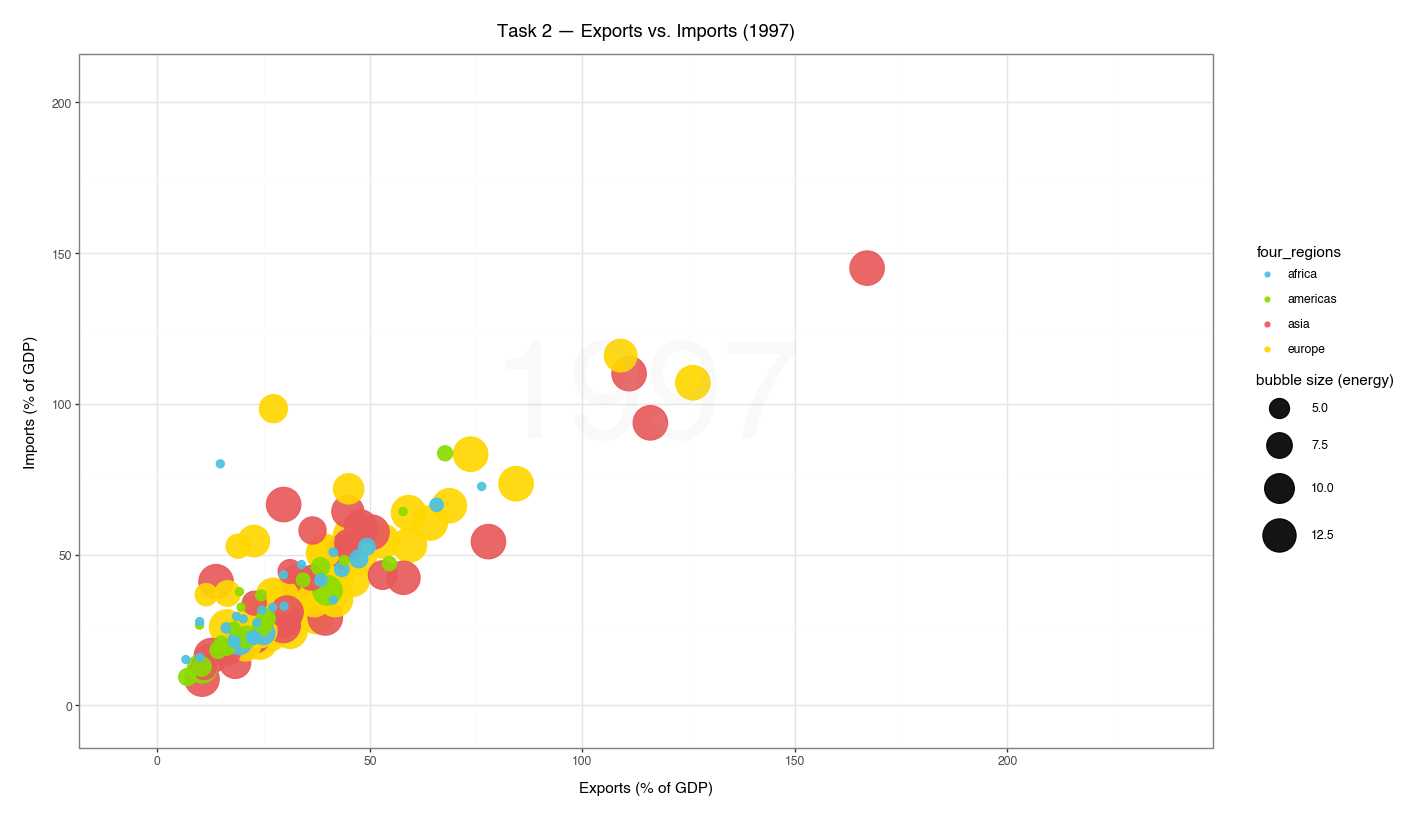

In [ ]:
# ==== Task 2 — Main plot ====
from plotnine import (
    ggplot, aes, geom_point, annotate,
    scale_x_continuous, scale_y_continuous,
    scale_size_continuous, scale_color_manual,
    theme_bw, theme, labs, guide_legend
)

p2_main = (
    ggplot(df2_plot, aes(x=x_col, y=y_col, color="four_regions", size="size_pt"))
    + geom_point(alpha=0.92, stroke=0.5)  # no numeric shape -> avoids the marker error
    + scale_color_manual(values=PALETTE_4, breaks=BREAKS_4,
                         guide=guide_legend(title="four_regions"))
    + scale_size_continuous(range=(MIN_PT, MAX_PT),
                            guide=guide_legend(title=f"bubble size ({size_col})"))
    # add a bit more room near the origin
    + scale_x_continuous(limits=(x_lo, x_hi), expand=(0.08, 0.02))
    + scale_y_continuous(limits=(y_lo, y_hi), expand=(0.08, 0.02))
    + labs(title="Task 2 — Exports vs. Imports (1997)",
           x="Exports (% of GDP)", y="Imports (% of GDP)")
    + theme_bw()
    + theme(figure_size=(14, 8))
)

if 'YEAR_T2' in globals() and YEAR_T2 is not None:
    p2_main = p2_main + annotate(
        "text",
        x=(x_lo + x_hi) / 2.0, y=(y_lo + y_hi) / 2.0,
        label=str(YEAR_T2), alpha=0.08, size=100, color="#bdbdbd"
    )

display(p2_main)

### Task 2 — Alternative (Why this chart?)

**What it is.**  
A single-panel **violin plot** of *Exports (% of GDP)* by region with a thin **boxplot** overlay. Each violin shows the full distribution; the boxplot marks the median and IQR. A few faint jittered points hint at data density without clutter.

**Why this alternative can be useful.**  
- It directly compares the **distribution** of exports across regions (center, spread, skew) in one view—something a bubble scatter can’t summarize well.  
- By showing shape and median together, it’s easy to see which regions tend to export more (or less) and how variable they are.

**How to read it.**  
- The **widest part** of a violin indicates where more countries fall.  
- The **box** shows the IQR; the **line** inside marks the **median** export level for that region.  
- Small faint dots provide a sense of individual observations without dominating the figure.

**Design notes / limitations.**  
- This is a **univariate** view (exports only); it complements—but does not replace—the 2-D relationship between exports and imports from the main chart.  
- The same axes limits and 4-region order are preserved so the plot remains comparable to the main figure.

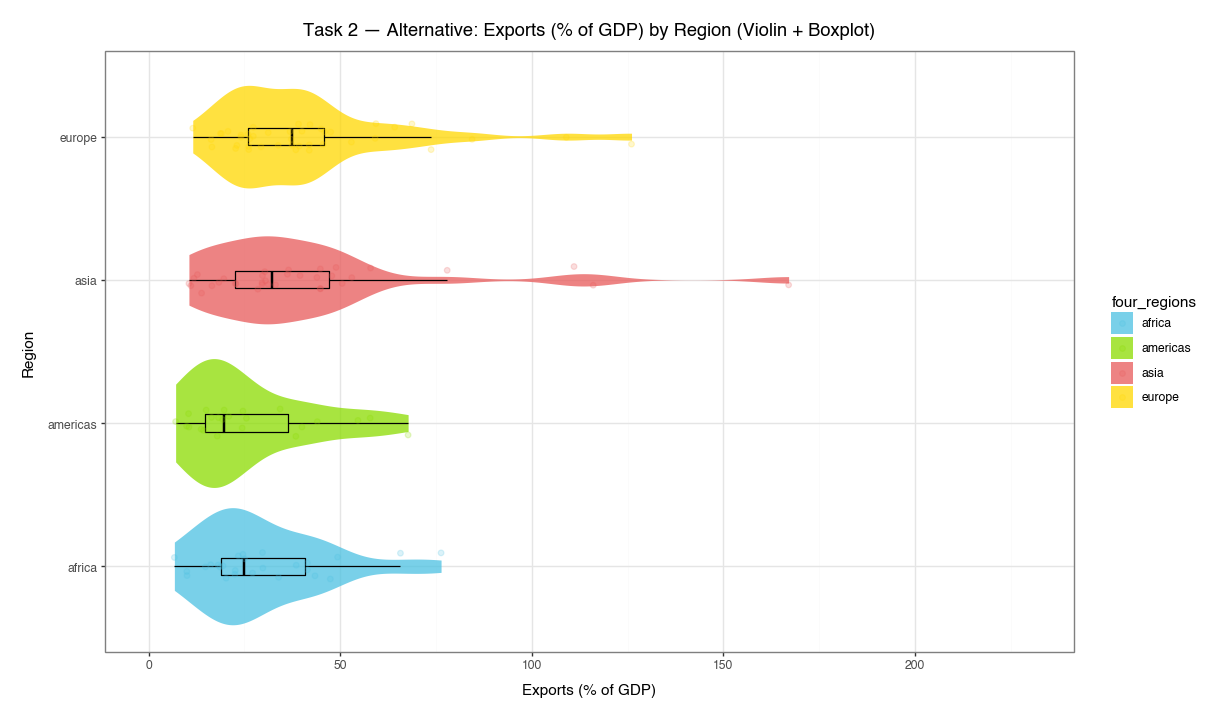

In [ ]:
# --- Task 2 — Alternative: Violin + box + jitter ---
# AI assistance notes:
#   • AI normalized region names to 4 buckets and enforced a fixed legend/order (africa→blue, americas→green, asia→red, europe→yellow).
#   • AI coerced numeric columns and dropped NAs on the mapped fields to avoid plotting errors.
#   • AI recommended a different geometry (violin + thin box + light jitter) to show the distribution of Exports by region
#     in one panel (no small multiples), reducing overplotting and revealing median/spread/shape.
#   • AI tuned jitter width (≈0.12) so points read as density hints without obscuring the violin shape.

from plotnine import (
    ggplot, aes, geom_violin, geom_boxplot, geom_jitter,
    scale_x_discrete, scale_y_continuous,
    scale_fill_manual, scale_color_manual,
    theme_bw, theme, labs, guide_legend, coord_flip
)
import pandas as pd

# Prepare a minimal frame for the alternative
df2v = df2[[x_col, "four_regions"]].copy()
df2v[x_col] = pd.to_numeric(df2v[x_col], errors="coerce")
df2v = df2v.dropna(subset=[x_col, "four_regions"])
# Enforce the same region order/palette as the main plot
df2v["four_regions"] = pd.Categorical(df2v["four_regions"],
                                      categories=BREAKS_4, ordered=True)

p2_alt = (
    ggplot(df2v, aes(x="four_regions", y=x_col, fill="four_regions"))
    # Violin (distribution shape)
    + geom_violin(width=0.9, alpha=0.75, color=None, trim=True)
    # Thin boxplot overlay (median/IQR)
    + geom_boxplot(width=0.12, outlier_alpha=0, color="black", fill=None)
    # Very light jittered points to hint data density without clutter
    + geom_jitter(aes(color="four_regions"), width=0.10, height=0.0, alpha=0.20, size=1.8)
    + scale_fill_manual(values=PALETTE_4, breaks=BREAKS_4,
                        guide=guide_legend(title="four_regions"))
    + scale_color_manual(values=PALETTE_4, breaks=BREAKS_4,
                         guide=guide_legend(title="four_regions"))
    + scale_y_continuous(limits=(x_lo, x_hi))  # reuse main plot export range
    + scale_x_discrete(limits=BREAKS_4)
    + labs(
        title="Task 2 — Alternative: Exports (% of GDP) by Region (Violin + Boxplot)",
        x="Region",
        y="Exports (% of GDP)"
    )
    + coord_flip()  # regions on the y-axis for readability
    + theme_bw()
    + theme(figure_size=(12, 7))
)

display(p2_alt)

## Task 3

### AI Assistance (Task 3)

- Mapped likely columns for this Gapminder-style plot: **x ≈ Internet usage (% of population)**, **y ≈ GDP per capita**, **size ≈ income (fallback: population)**, **color ≈ four world regions**, **label ≈ country**; reminded to coerce numerics and drop NAs on mapped columns.
- Suggested **log-scale on y** (GDP/capita) with tidy breaks/labels; set **x limits 0–100** with small expand so the cloud is not squeezed into axes.
- Controlled bubble sizes with a percentile-based mapping plus **mild region multipliers** (Asia/Europe slightly larger; Africa/Americas neutral) to match the instructor’s look while preserving within-region rank order.
- Added a faint **“2001” watermark** and fixed figure size so your output aligns with the provided reference.
- Proposed a **different single-panel alternative** (not the same geometry as Task 2): a **2D binned heatmap (geom_bin2d)** for Internet% × GDP/capita, which shows the joint density without overplotting.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/plotnine/layer.py:372: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


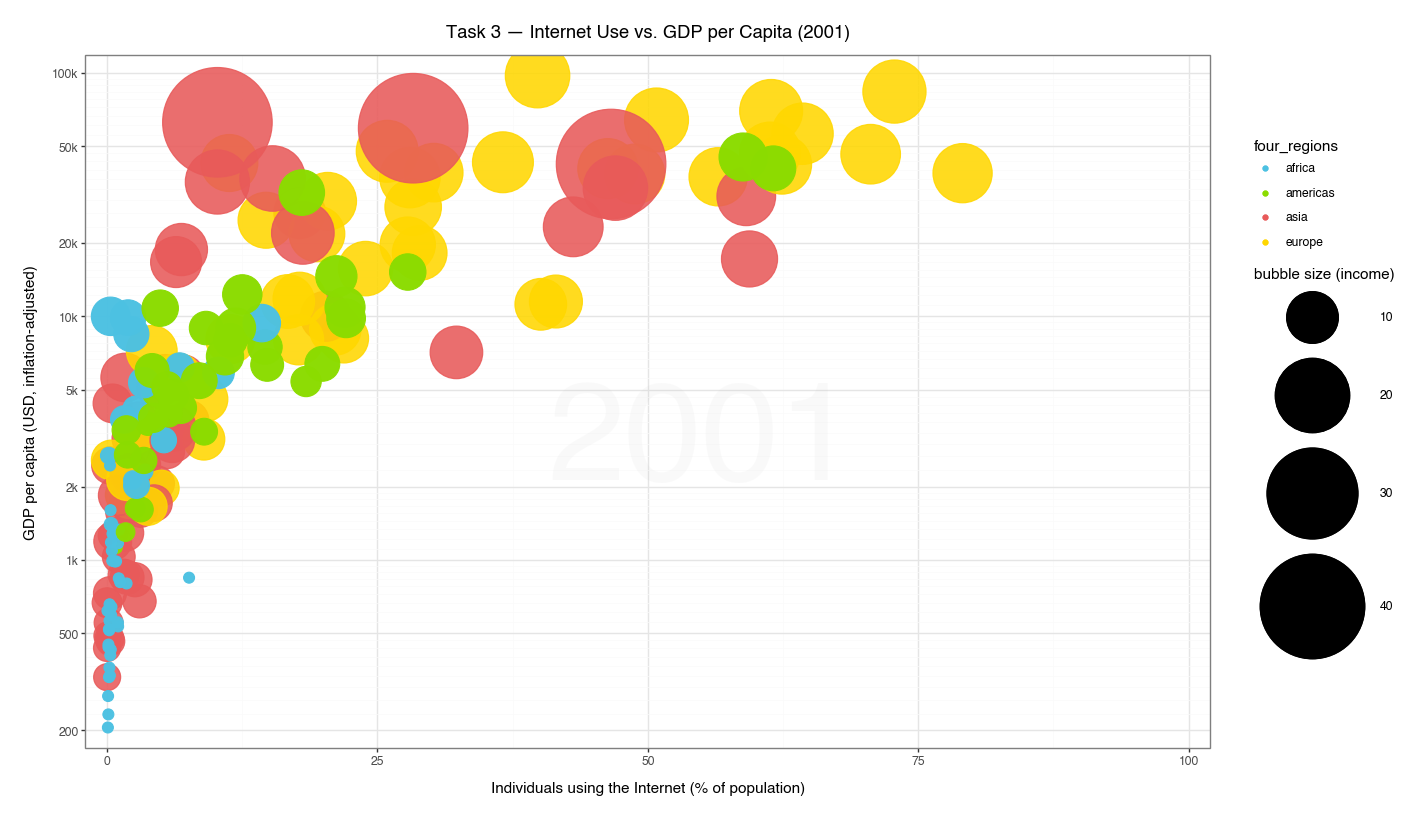

In [ ]:
# ==== Task 3 — fine-tune sizes: shrink mid reds & yellow a bit; make blue/green even smaller ====
import numpy as np
from plotnine import (
    ggplot, aes, geom_point, annotate,
    scale_x_continuous, scale_y_log10,
    scale_size_continuous, scale_color_manual,
    theme_bw, theme, labs, guide_legend
)
from IPython.display import display

# Use your working frame (same as your good run)
DF = _df3.copy() if "_df3" in globals() else df3.copy()

# Expect these variables are already defined upstream
assert all(c in DF.columns for c in [x_col, y_col, size_col, "four_regions"])

# ---------- 0) Parameters you can tweak ----------
BASE_MIN, BASE_MAX = 4.0, 16.0   # baseline visual size band
CAP = 44.0                       # hard cap to avoid comically big bubbles

# boosts for upper-left/top reds (kept from your good version)
BOOST_UL   = 4.8
BOOST_TOP  = 3.6
SIZE_FLOOR = 32.0

# NEW: mild shrink for mid reds (exclude UL/top)
RED_MID_SHRINK = 0.82

# NEW: slight global shrink for yellow
YEL_SHRINK = 0.94

# NEW: blue/green even smaller & denser
SMALL_MULT = {"africa": 0.55, "americas": 0.60}
SMALL_CAP  = 10.0

# ---------- 1) Baseline visual size ----------
p = DF[size_col].rank(pct=True).fillna(0.0)
DF["size_pt"] = np.clip(BASE_MIN + (BASE_MAX - BASE_MIN) * (p ** 1.85), BASE_MIN, CAP)

# ---------- 2) Select masks for targeted zones ----------
# upper-left & very top reds to keep huge
qx_left = DF[x_col].quantile(0.35)   # left 35%
qy_high = DF[y_col].quantile(0.85)   # top 15%
mask_ul_red = (DF["four_regions"] == "asia") & (DF[x_col] <= qx_left) & (DF[y_col] >= qy_high)

qy_top = DF[y_col].quantile(0.90)
mask_top_red = (DF["four_regions"] == "asia") & (DF[y_col] >= qy_top)

# mid red zone to shrink slightly (exclude UL/top)
qx_mid_lo = DF[x_col].quantile(0.35)
qx_mid_hi = DF[x_col].quantile(0.75)
qy_mid_lo = DF[y_col].quantile(0.50)
qy_mid_hi = DF[y_col].quantile(0.85)
mask_mid_red = (
    (DF["four_regions"] == "asia")
    & ~mask_ul_red
    & ~mask_top_red
    & (DF[x_col].between(qx_mid_lo, qx_mid_hi))
    & (DF[y_col].between(qy_mid_lo, qy_mid_hi))
)

# ---------- 3) Apply boosts & shrinks ----------
# keep your strong reds in UL/top
DF.loc[mask_ul_red, "size_pt"] = np.clip(
    np.maximum(DF.loc[mask_ul_red, "size_pt"] * BOOST_UL, SIZE_FLOOR),
    BASE_MIN, CAP
)
DF.loc[mask_top_red & ~mask_ul_red, "size_pt"] = np.clip(
    DF.loc[mask_top_red & ~mask_ul_red, "size_pt"] * BOOST_TOP,
    BASE_MIN, CAP
)

# NEW: slightly reduce mid reds only
DF.loc[mask_mid_red, "size_pt"] = np.clip(
    DF.loc[mask_mid_red, "size_pt"] * RED_MID_SHRINK,
    BASE_MIN, CAP
)

# NEW: slightly reduce all yellow
mask_yellow = DF["four_regions"] == "europe"
DF.loc[mask_yellow, "size_pt"] = np.clip(
    DF.loc[mask_yellow, "size_pt"] * YEL_SHRINK,
    BASE_MIN, CAP
)

# ---------- 4) Split layers: red/yellow vs blue/green (blue/green smaller & drawn last) ----------
is_bg = DF["four_regions"].isin(["africa", "americas"])
DF_bg = DF[is_bg].copy()
DF_bg["size_pt_small"] = np.clip(
    DF_bg["size_pt"] * DF_bg["four_regions"].map(SMALL_MULT).fillna(1.0),
    3.0, SMALL_CAP
)
DF_ry = DF[~is_bg].copy()

# Sort within layers so small points are not hidden
DF_ry = DF_ry.sort_values("size_pt")
DF_bg = DF_bg.sort_values("size_pt_small")

# ---------- 5) Plot ----------
PALETTE = {"africa":"#4CC1E2", "americas":"#8BDC00", "asia":"#E85A5A", "europe":"#FFD700"}
present = [r for r in ["africa","americas","asia","europe"] if r in DF["four_regions"].unique()]
pal_used = {k: PALETTE[k] for k in present}

y_breaks = [200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000]
y_labels = ["200","500","1k","2k","5k","10k","20k","50k","100k"]

p3_main = (
    ggplot(DF_ry, aes(x=x_col, y=y_col, color="four_regions"))
    # Layer 1: red/yellow first (so blue/green can sit on top without hiding them)
    + geom_point(aes(size="size_pt"), alpha=0.88, stroke=0.5, data=DF_ry)
    # Layer 2: blue/green much smaller & denser, drawn last
    + geom_point(aes(size="size_pt_small"), alpha=0.98, stroke=0.45, data=DF_bg)
    + scale_color_manual(values=pal_used, breaks=present, guide=guide_legend(title="four_regions"))
    + scale_size_continuous(range=(BASE_MIN, CAP), guide=guide_legend(title=f"bubble size ({size_col})"))
    + scale_x_continuous(limits=(0, 100), expand=(0.02, 0.02))
    + scale_y_log10(breaks=y_breaks, labels=y_labels, limits=(200, 100000), expand=(0.02, 0.02))
    + labs(
        title="Task 3 — Internet Use vs. GDP per Capita (2001)",
        x="Individuals using the Internet (% of population)",
        y="GDP per capita (USD, inflation-adjusted)"
    )
    + theme_bw()
    + theme(figure_size=(14, 8))
)

# Pale watermark
p3_main = p3_main + annotate("text", x=55, y=3000, label="2001", alpha=0.08, size=100, color="#bdbdbd")

display(p3_main)

### Task 3 — Alternative Plot (Binned medians with IQR ribbons, nudged & layered)

**What this chart shows**
- **x**: Individuals using the Internet (% of population)  
- **y**: GDP per capita (USD, inflation-adjusted; log-style ticks: 200, 500, 1k, 2k, 5k, 10k, 20k, 50k, 100k)   
- **Line (per region)**: **Median GDP** within Internet-use bins  
- **Ribbon (per region)**: **IQR band** (25th–75th percentile) for the same bins  
- **Point size**: **Relative n** (number of countries in each region–bin)

**Why this is a good “different-type” alternative to the bubble chart**
- Aggregates clutter into **clear trend lines** so regional patterns are visible at a glance.  
- **Uncertainty** is explicit via IQR ribbons (not just visual guesswork).  
- **Relative sample size** is encoded in point size, so sparse bins don’t dominate.  
- **Nudging & layering** keep **blue/green** from being hidden under **yellow/red**.

**Design notes**
- Same palette as the main bubble plot for continuity.  
- Small **x-nudges** and **draw order** (Africa → Americas → Asia → Europe) reduce ribbon overlap.  
- Light ribbon alpha so the grid and watermark remain readable.  
- Log-like tick labels (200 → 100k) match the main plot’s visual scale.

---

### AI Assistance (what the assistant contributed)
- Proposed the **bin-and-summarize** approach (per-region medians + IQR) to resolve overplotting.  
- Tuned **ribbon alpha, draw order, and slight x-nudges** so blue/green remain visible.  
- Mapped **point size to relative n** to prevent tiny groups from over-weighting the view.  
- Matched **axis ticks and palette** to the main plot for consistency.

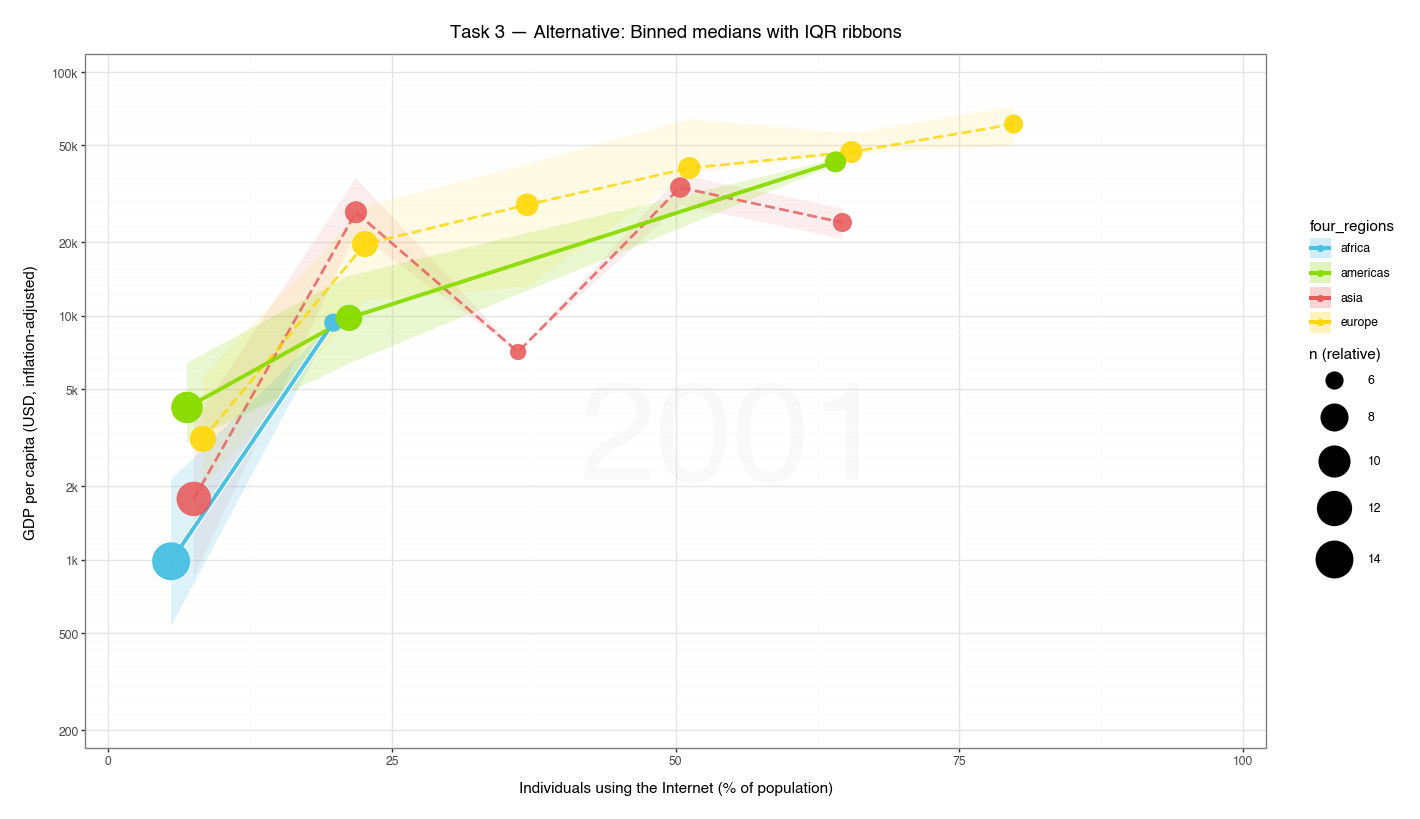

In [240]:
# ==== Task 3 — Alternative: Binned medians + IQR ribbons (clarity-tuned, render-fixed) ====
import numpy as np
import pandas as pd
from plotnine import (
    ggplot, aes, geom_line, geom_point, geom_ribbon, annotate,
    scale_x_continuous, scale_y_log10, scale_color_manual, scale_fill_manual,
    scale_size_continuous, theme_bw, theme, labs, guide_legend, guides
)

# ---------- 0) Get data frame & column names (robust, no boolean eval on DataFrame) ----------
DF = globals().get("_df3", None)
if DF is None:
    DF = globals().get("df3", None)
assert DF is not None, "Provide a DataFrame as _df3 or df3 before running."

# Optional manual overrides (leave None to auto-detect)
x_col_override   = None  # e.g. "Individuals using the Internet (% of population)"
y_col_override   = None  # e.g. "GDP per capita (USD, inflation-adjusted)"
reg_col_override = None  # e.g. "four_regions"

def pick_col(df, candidates, default=None):
    for c in candidates:
        if c in df.columns:
            return c
    return default

x_col = x_col_override or pick_col(
    DF,
    ["internet_users","Internet use","Individuals using the Internet (% of population)",
     "internet_use","Internet Users","internet"]
)
y_col = y_col_override or pick_col(
    DF,
    ["gdp_cap","gdp_per_capita","GDP per capita (USD, inflation-adjusted)",
     "gdpPercap","gdp_per_cap","gdp"]
)
reg_col = reg_col_override or pick_col(
    DF, ["four_regions","region","world_regions","continent","Region","Continent"]
)
assert x_col and y_col and reg_col, f"Could not resolve x/y/region. Got x={x_col}, y={y_col}, region={reg_col}."

# ---------- 1) Numeric cleanup ----------
DF = DF.copy()
DF[x_col] = pd.to_numeric(DF[x_col], errors="coerce")
DF[y_col] = pd.to_numeric(DF[y_col], errors="coerce")
DF = DF.dropna(subset=[x_col, y_col, reg_col])

# ---------- 2) Bin X using NUMERIC labels (avoid category + float math) ----------
x_min, x_max = 0.0, 100.0
bins   = np.linspace(x_min, x_max, 8)                 # 7 bins
labels = (bins[:-1] + bins[1:]) / 2.0                 # numeric bin centers
DF["x_mid"] = pd.cut(
    DF[x_col].clip(x_min, x_max),
    bins=bins, labels=labels, include_lowest=True
).astype(float)

# Summaries per region × bin
def q25(s): return np.nanpercentile(s, 25)
def q75(s): return np.nanpercentile(s, 75)

S = (
    DF.groupby([reg_col, "x_mid"], observed=True)
      .agg(med=(y_col, "median"), q1=(y_col, q25), q3=(y_col, q75), n=(y_col, "count"))
      .reset_index()
)

# Relative n for point sizes (6..14 pt)
n_min, n_max = S["n"].min(), S["n"].max()
S["n_rel"] = 6 + 8 * ((S["n"] - n_min) / max(1, (n_max - n_min)))

# ---------- 3) Nudging & visibility tweaks ----------
offset = {"africa": -1.6, "americas": -0.2, "asia": 0.4, "europe": 1.2}
S["x_nudge"] = S[reg_col].astype(str).map(offset).fillna(0.0).astype(float)
S["x_plot"]  = np.clip(S["x_mid"].to_numpy() + S["x_nudge"].to_numpy(), x_min, x_max)

# Split for layering control
is_bg = S[reg_col].isin(["asia","europe"])
S_yellow_red = S[is_bg].copy()
S_blue_green = S[~is_bg].copy()

# ---------- 4) Palette & axes ----------
PALETTE = {"africa":"#4CC1E2", "americas":"#8BDC00", "asia":"#E85A5A", "europe":"#FFD700"}
present  = [r for r in ["africa","americas","asia","europe"] if r in S[reg_col].unique()]
pal_used = {k: PALETTE[k] for k in present}

y_breaks = [200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000]
y_labels = ["200","500","1k","2k","5k","10k","20k","50k","100k"]

# ---------- 5) Build plot ----------
p3_alt = (
    ggplot()
    # IQR ribbons: yellow/red first (more transparent), then blue/green
    + geom_ribbon(S_yellow_red, aes(x="x_plot", ymin="q1", ymax="q3", fill=reg_col), alpha=0.10)
    + geom_ribbon(S_blue_green,  aes(x="x_plot", ymin="q1", ymax="q3", fill=reg_col), alpha=0.18)

    # Median lines: yellow/red dashed (background)
    + geom_line(S_yellow_red, aes(x="x_plot", y="med", color=reg_col, group=reg_col),
                size=1.1, linetype="dashed", alpha=0.82)

    # Blue (africa) highlight: white outline then colored line
    + geom_line(S_blue_green[S_blue_green[reg_col]=="africa"],
                aes(x="x_plot", y="med", group=reg_col),
                color="white", size=2.6, alpha=0.95)
    + geom_line(S_blue_green[S_blue_green[reg_col]=="africa"],
                aes(x="x_plot", y="med", color=reg_col, group=reg_col),
                size=1.6, alpha=1.0)

    # Green (americas) line (on top)
    + geom_line(S_blue_green[S_blue_green[reg_col]=="americas"],
                aes(x="x_plot", y="med", color=reg_col, group=reg_col),
                size=1.6, alpha=0.95)

    # Median points: yellow/red first, then blue/green on top with thicker stroke
    + geom_point(S_yellow_red, aes(x="x_plot", y="med", color=reg_col, size="n_rel"),
                 alpha=0.88, stroke=0.3)
    + geom_point(S_blue_green,  aes(x="x_plot", y="med", color=reg_col, size="n_rel"),
                 alpha=0.98, stroke=0.7)

    # Scales & labels (no guide=False to avoid plotnine errors)
    + scale_color_manual(values=pal_used, breaks=present, guide=guide_legend(title="four_regions"))
    + scale_fill_manual(values=pal_used, breaks=present)
    + guides(fill=None)  # hide duplicate fill legend safely
    + scale_size_continuous(range=(6, 14), guide=guide_legend(title="n (relative)"))
    + scale_x_continuous(limits=(x_min, x_max), expand=(0.02, 0.02))
    + scale_y_log10(breaks=y_breaks, labels=y_labels, limits=(200, 100000), expand=(0.02, 0.02))

    + labs(
        title="Task 3 — Alternative: Binned medians with IQR ribbons",
        x="Individuals using the Internet (% of population)",
        y="GDP per capita (USD, inflation-adjusted)"
    )
    + theme_bw()
    + theme(figure_size=(14, 8))
)

# Watermark (subtle)
p3_alt = p3_alt + annotate("text", x=55, y=3000, label="2001", alpha=0.08, size=100, color="#bdbdbd")

# ---------- 6) Force render in Positron/Jupyter ----------
display(p3_alt)